<a href="https://colab.research.google.com/github/ViniMBlanco/DesafioBancodeTalentoCatiJr/blob/main/ProjectCatiJR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio de Dados – Banco de Talentos

## Configurações iniciais

In [1]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Carregar dados
df_train = pd.read_csv("train.csv")

print("Dimensões do dataset de treino:", df_train.shape)
df_train.head()



Dimensões do dataset de treino: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train.info()

df_train.describe().T

# Verificando valores ausentes
df_train.isnull().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageFinish,81
GarageType,81


Com isso, é possível verificar os conteúdos das colunas, se ele está com valores faltantes. Se sim, deve analisar quantos são e se é ou não interessante para trabalhar.

In [24]:
#Testando inconsistência nos valores de MasVnrArea e MasVnrType
mask = (df_train['MasVnrArea'] == 0) | (df_train['MasVnrArea'].isnull())
display(df_train[mask][['MasVnrArea', 'MasVnrType', 'SalePrice']])

,MasVnrArea,MasVnrType,SalePrice
1,0.0,NaN,181500
3,0.0,NaN,140000
5,0.0,NaN,143000
8,0.0,NaN,129900
9,0.0,NaN,118000
...,...,...,...
1454,0.0,NaN,185000
1455,0.0,NaN,175000
1457,0.0,NaN,266500
1458,0.0,NaN,142125


Como análise possível desses valores, é possível entender:

1. *PoolQC, MiscFeature, Alley, Fence, MasVnrType, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageYrBlt, GarageCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1/2* : Faz sentido ter valores nulos, pois seria como não tivesse a estrutura citada. O que vale a pena manter e deixar claro para a análise.

2.  *Electrical*: Um valor nulo é lido como faltante nesse caso, logo deve ser preenchido pela moda para não interferir na análise.

3. *LotFrontage*: Representam o tamanho da frente do lote e apresenta valores faltantes, é interessante preenchê-los com a média do *LotFrontage* por bairro.

4. *MasVnrType* e *MasVnrArea* com insconsistências: Caso *MasVnrType* seja valor nulo, logo não vai ter revestimento de alvenaria e a *MasVnrArea* deve ser 0(nulo). O que não ocorre.

 Analisando esse quarto caso, é possível perceber que apenas esses 8 casos de *MasVnrArea* são valores faltantes. Contudo, também há casos onde a área é 0, porém tem material de revestimento, o que não faz sentido.  

In [5]:
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_train.select_dtypes(include=['object']).columns

print("Numéricas:", len(num_cols))
print("Categóricas:", len(cat_cols))

Numéricas: 38
Categóricas: 43


## Lidar com valores Nulos.

### 1. Deixando claro valores Nulos

In [6]:
# Removendo Id, pois inútil para análise
df_clean = df_train.drop(['Id'], axis=1)

# preenchendo os valores nulos com o valor descrito no dataset "NA"
for name in df_clean.select_dtypes("object"):
    df_clean[name] = df_clean[name].fillna("NA")

df_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


### 2. Correção da coluna Electrical

In [7]:
df_clean['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])


In [8]:
print(df_clean['Electrical'].value_counts(dropna=False))

Electrical
SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64


### 3. Preenchendo LotFrontage com média por bairro

In [9]:
df_clean['LotFrontage'] = df_train.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

In [10]:
print(df_clean['LotFrontage'].isnull().sum())

0


### 4. Corrigindo insconsistências MasVnrType e MasVnrArea  

In [25]:
df_clean['MasVnrType'] = df_clean['MasVnrType'].fillna('None')

# Substituir NaN em MasVnrArea por 0 (ausência de revestimento)
df_clean['MasVnrArea'] = df_clean['MasVnrArea'].fillna(0)

# Corrigir casos inconsistentes: tipo != None mas área = 0
mask_inconsistent = (df_clean['MasVnrType'] != 'None') & (df_clean['MasVnrArea'] == 0)
for t in df_clean.loc[mask_inconsistent, 'MasVnrType'].unique():
    median_area = df_clean.loc[df_clean['MasVnrType'] == t, 'MasVnrArea'].median()
    df_clean.loc[(df_clean['MasVnrType'] == t) & (df_clean['MasVnrArea'] == 0), 'MasVnrArea'] = median_area

# 4. Corrigir casos opostos: tipo = None mas área > 0
mask_inconsistent2 = (df_clean['MasVnrType'] == 'None') & (df_clean['MasVnrArea'] > 0)
df_clean.loc[mask_inconsistent2, 'MasVnrType'] = 'BrkFace'  # Exemplo: usar o tipo mais comum

# Verificação final
df_clean[['MasVnrType', 'MasVnrArea']].isnull().sum(), df_clean[['MasVnrType', 'MasVnrArea']].head(10)


(MasVnrType    0
 MasVnrArea    0
 dtype: int64,
   MasVnrType  MasVnrArea
 0    BrkFace       196.0
 1         NA         0.0
 2    BrkFace       162.0
 3         NA         0.0
 4    BrkFace       350.0
 5         NA         0.0
 6      Stone       186.0
 7      Stone       240.0
 8         NA         0.0
 9         NA         0.0)

In [26]:
mask = (df_clean['MasVnrArea'] == 0) | (df_clean['MasVnrArea'].isnull())
display(df_clean[mask][['MasVnrArea', 'MasVnrType', 'SalePrice']])

,MasVnrArea,MasVnrType,SalePrice
1,0.0,NA,181500
3,0.0,NA,140000
5,0.0,NA,143000
8,0.0,NA,129900
9,0.0,NA,118000
...,...,...,...
1454,0.0,NA,185000
1455,0.0,NA,175000
1457,0.0,NA,266500
1458,0.0,NA,142125


## Tratando Outliers

### Variáveis Numéricas

In [13]:
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

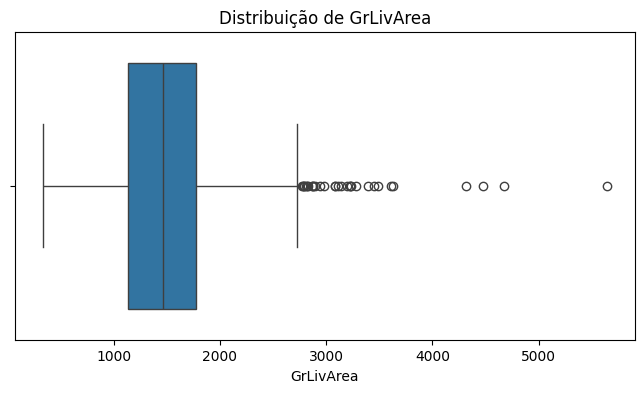

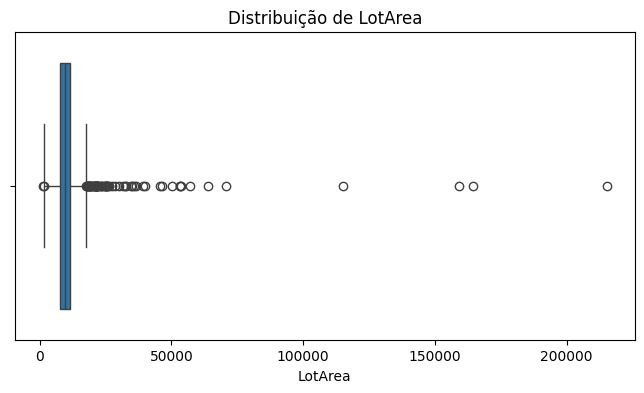

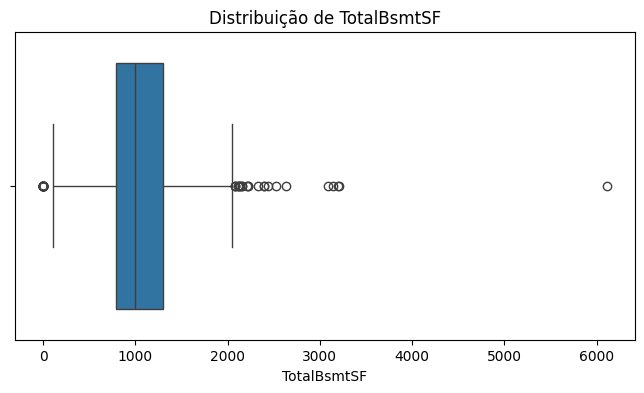

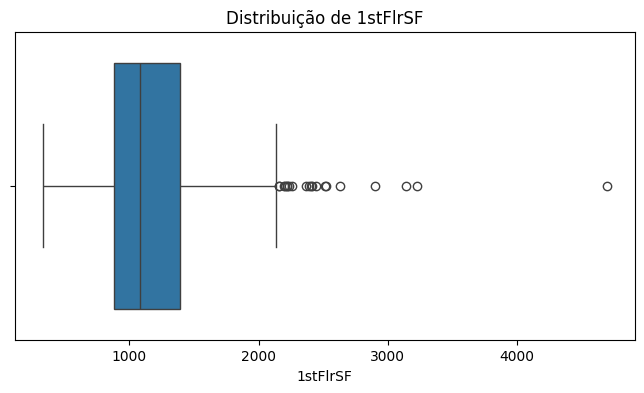

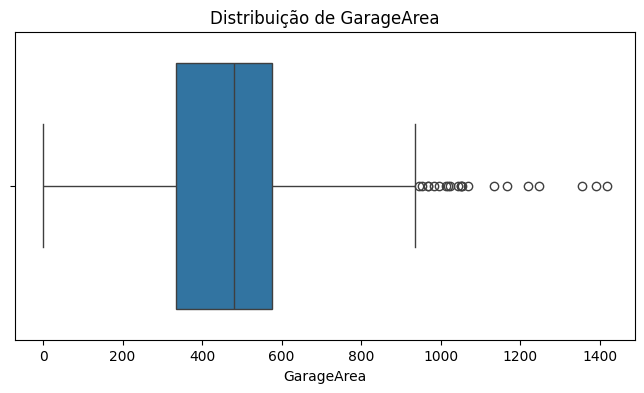

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in ['GrLivArea', 'LotArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea']:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df_clean[col])
    plt.title(f'Distribuição de {col}')
    plt.show()


Logo, é visível alguns outliers, porém tem que verificar a validade para manter nessa análise.
Áreas extremamente grande que não fazem muito impacto no preço devem ser removidas.

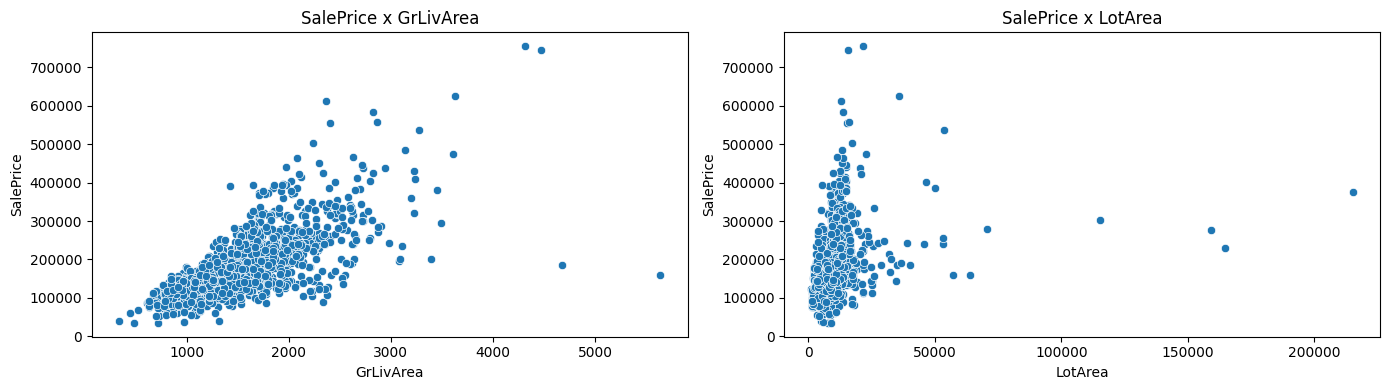

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_clean, ax=axes[0])
axes[0].set_title('SalePrice x GrLivArea')

sns.scatterplot(x='LotArea', y='SalePrice', data=df_clean, ax=axes[1])
axes[1].set_title('SalePrice x LotArea')

plt.tight_layout()
plt.show()

As variáveis GrLivArea, LotArea apresentou valores muito altos (acima de 100.000 ft² para LotArea e 4000 para GvLivArea), que correspondem a poucos casos de propriedades extremamente grandes, fora do padrão urbano observado na maioria das residências.

Esses pontos distorcem medidas de tendência central e análises gráficas.
Optou-se por remover tais registros, mantendo o foco em residências típicas e melhorando a representatividade estatística da amostra.

In [16]:
# Removendo outliers de GrLivArea e LotArea diretamente em df_clean

df_clean = df_clean[
    ~(
        ((df_clean['GrLivArea'] > 4000) & (df_clean['SalePrice'] < 300000)) |
        (df_clean['LotArea'] > 100000)
    )
]

print("Dimensão após remover outliers:", df_clean.shape)

Dimensão após remover outliers: (1454, 80)


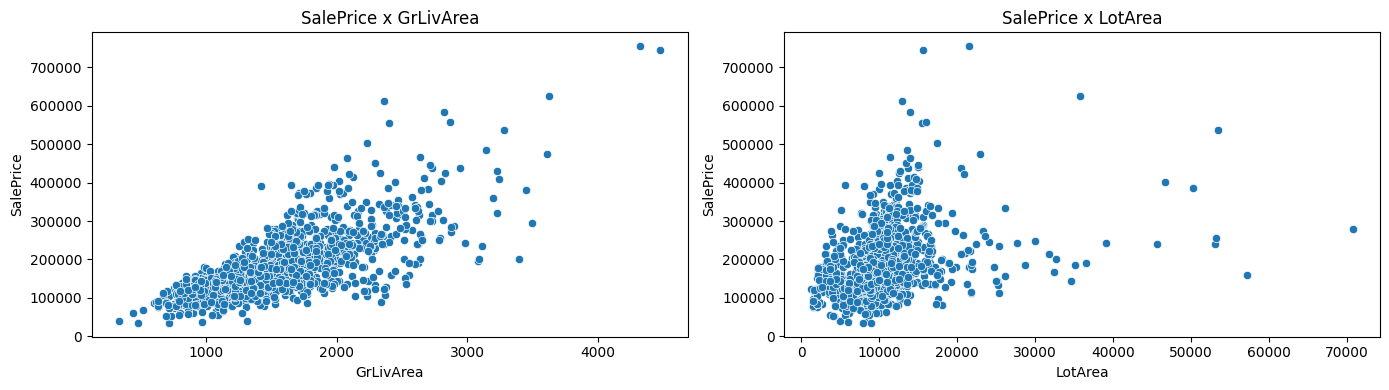

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_clean, ax=axes[0])
axes[0].set_title('SalePrice x GrLivArea')

sns.scatterplot(x='LotArea', y='SalePrice', data=df_clean, ax=axes[1])
axes[1].set_title('SalePrice x LotArea')

plt.tight_layout()
plt.show()

### Conclusão sobre Outliers

Logo, removemos os valores onde GrLivArea maior que 4000 e o SalePrice menor 300000. Além de remover também os valores onde LotArea maior que 100000 e SalePrice menor que 300000, a fim de resultar numa melhor análise e evitar uma distorção nos gráficos e correlações.

## Correlações Com SalePrice(Dashboards e Conclusões)

### Variáveis  Numéricas

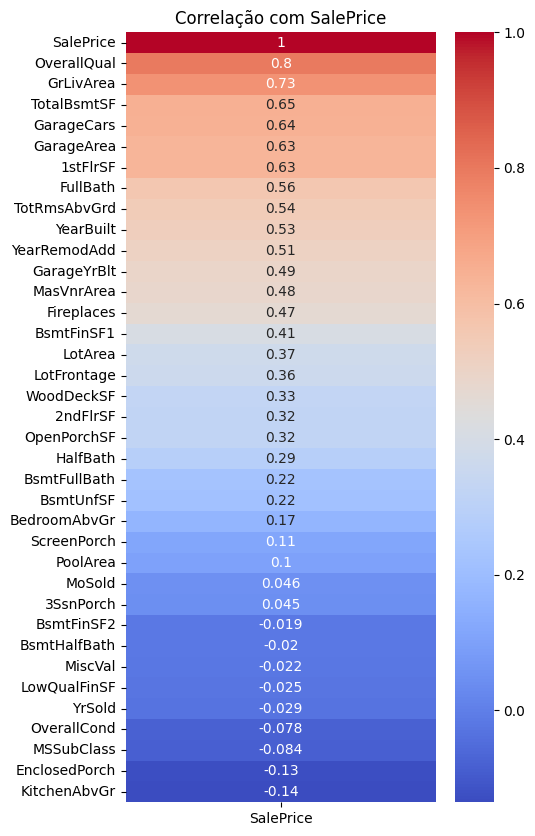

In [18]:
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
corr = df_clean[num_cols].corr()['SalePrice'].sort_values(ascending=False)
plt.figure(figsize=(5, 10))
sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm")
plt.title("Correlação com SalePrice")
plt.show()

Aqui é possível ver as varíveis que mais afetam o SalePrice.

Explorando mais afundo as variáveis com mais correlação para visualização.

In [19]:
import plotly.express as px

fig1 = px.scatter(
    df_clean,
    x='GrLivArea',
    y='SalePrice',
    color='OverallQual',
    trendline="ols",
    opacity=0.7,
    title='Preço vs Área Habitável (colorido por Qualidade)'
)

fig1.show()

fig2 = px.box(df_clean, x='OverallQual', y='SalePrice',
              title='Distribuição do Preço por Qualidade Geral')
fig2.show()

fig3 = px.box(df_clean, x='GarageCars', y='SalePrice',
              title ='Distribuição do Preço por Tamanho da Garagem')
fig3.show()



### Conclusão Variáveis Numéricas

A partir da análise dos dashboards feitos, é possível analisar as variáveis mais influentes para o preço de venda das casas(*SalePrice*) a partir do heatmap, evidenciando os atributos **OverallQual** (qualidade geral da construção), **GrLivArea** (área habitável), **TotalBsmtSF** (área do porão), **GarageCars** e **GarageArea** (capacidade e área da garagem,os quais estão altamente relacionados, obviamente) e também **FullBath**(Quantidade de Banheiros).

Partindo para visualizar as variáveis mais influentes, mais que *0.7* na correlação(OverallQual e GrLivArea), é notório essa correlação entre essas duas variáveis, como no gráfico *Preço vs Área Habitável (colorido por Qualidade)*, mostrando que começa a aparecer casas com a qualidade geral acima de 8(aproximadamente) a partir de 1500 de *área habitável*, sendo extremamente raro de aparecer antes desse limite. Além de que é visível a crescente no gráfico pela reta vermelha de Regressão traçada.

Além disso, é mostrada um boxplot para a variável mais influente **OverallQual**, onde tem um forte noção do preço das casas conforme a nota da qualidade geral aumenta e foi mostrada a boxplot para a variável **GarageCars** que está diretamente relacionada com o preço mostrando que Casas com garagens para 3 carros consegue ter um aumento de preço médio.

### Variáveis Categóricas

In [20]:
cat_cols = df_clean.select_dtypes(include=['object']).columns

influencias = []

for col in cat_cols:

    df_group = (
        df_clean.groupby(col, dropna=False)['SalePrice']# Calculando no caso NaN, representando falta da estrutura
        .mean()
        .sort_values(ascending=False)
    )

    amplitude = df_group.max() - df_group.min() # Para medir variável mais correlacionada
    influencias.append((col, amplitude))

    print(f"\n{col} — variação média do preço:")
    print(df_group)




MSZoning — variação média do preço:
MSZoning
FV         214014.061538
RL         190671.658515
RH         131558.375000
RM         126316.830275
C (all)     74528.000000
Name: SalePrice, dtype: float64

Street — variação média do preço:
Street
Pave    180859.249827
Grvl    110438.600000
Name: SalePrice, dtype: float64

Alley — variação média do preço:
Alley
NA      183138.861335
Pave    168000.585366
Grvl    122219.080000
Name: SalePrice, dtype: float64

LotShape — variação média do preço:
LotShape
IR2    237286.358974
IR1    206098.560166
IR3    203170.625000
Reg    164754.818378
Name: SalePrice, dtype: float64

LandContour — variação média do preço:
LandContour
HLS    231586.673469
Low    193266.666667
Lvl    180183.746758
Bnk    142144.377049
Name: SalePrice, dtype: float64

Utilities — variação média do preço:
Utilities
AllPub    180646.76256
NoSeWa    137500.00000
Name: SalePrice, dtype: float64

LotConfig — variação média do preço:
LotConfig
CulDSac    222427.543478
FR3        2

In [21]:
 #Criar DataFrame com as amplitudes
influencias_df = pd.DataFrame(influencias, columns=['Variável', 'Amplitude_média'])
influencias_df = influencias_df.sort_values(by='Amplitude_média', ascending=False)

print("\n Variáveis categóricas mais influentes (diferença média de preço):")
print(influencias_df.head(10))



 Variáveis categóricas mais influentes (diferença média de preço):
        Variável  Amplitude_média
38        PoolQC    309916.936464
10    Condition2    288250.000000
18     ExterQual    287175.185714
14      RoofMatl    253250.000000
8   Neighborhood    236718.846485
30   KitchenQual    226176.805076
21      BsmtQual    223987.578696
16   Exterior2nd    214000.000000
32   FireplaceQu    207948.350000
15   Exterior1st    191000.000000


In [22]:
import plotly.express as px

top_vars = influencias_df['Variável'].head(5)

for var in top_vars:
    fig = px.box(
        df_clean,
        x=var,
        y='SalePrice',
        title=f"Distribuição de SalePrice por {var}",
        points='outliers'  # mostra os outliers também
    )
    fig.show()

In [23]:
df_neigh = df_clean.groupby("Neighborhood")["SalePrice"].mean().sort_values(ascending=False).head(10)
px.bar(df_neigh, title="Top 10 Bairros por Preço Médio")


### Conclusão para Variáveis Categóricas

Após algumas contas em busca da melhor variável que influencia o *SalePrice* nesse DataSet, a melhor conclusão que cheguei foi utilizar a amplitude do preço das casas de cada variável.

Utilizando esses cálculos, foi possível identificar que algumas variáveis conseguem ter essa influência mesmo com poucos registros, como é o caso do **PoolQC**(Qualidade da piscina), além dela, outras variáveis foram evidenciadas como **Condition2**(Característica mais específica da casa, como estilo), **ExterQual** (Qualidade da área externa), **RoofMatl** (Material do Telhado) e **Neighborhood**(Bairro).

No caso da qualidade da piscina é possível observar que caso a qualidade da piscina for excelente(Ex), então mostra extrema relevância na influência do preço.

Já no atributo Condition2, após analisar mais afundo a variável, utilizando o boxplot, é possível perceber que essa característica não é evidenciada como influência do preço da casa, sendo grande parte das casas sendo representadas em casas normais (Norms) nesse atributo, tendo alta variação por conta dessa característica, não sendo muito boa para usar como parâmetro.

Os atributos Ex e Gd de ExterQual mostra uma grande diferença das parcelas de casas que ficam em Ta e Fa, mostrando que é de caráter diferencial ter uma área externa de qualidade. Partindo para o material do telhado, é visto que *WdShngl* tem maior potencial, seguido pelo mais comum *CompShg*, já os outros não tem um potencial grande para afetar positivamente o preço da casa.

Sobre os bairros, achei interessante produzir um gráfico mostrando o preço médio das casas no Top10 bairros, mostrando essa influência.'


## Modelo Preditivo

Com os padrões identificados,como a influência da qualidade geral, área habitável e localização, já é possível construir um modelo para prever o SalePrice. Para esse dataset, modelos como Random Forest ou Gradient Boosting(XGBoost ou LightGBM) funcionam melhor que uma regressão linear por capturarem relações não lineares entre as variáveis.

Mesmo com um train.csv e um test.csv, a validação deve ser feita dentro do próprio treinamento usando k-fold cross-validation, garantindo que o desempenho seja estável em diferentes partes dos dados. Métricas como RMSE e R² avaliam quão próximas as previsões ficam do valor real, enquanto técnicas de regularização ajudam a evitar overfitting antes de aplicar o modelo ao test.csv final.